In [1]:
# Database used: https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data
# TODO Maybe we should not be using pictures of glaciers, mountains, etc., just one single type of image
#  (for now)

import os
import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
import numpy as np

2024-01-06 19:10:48.006405: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 19:10:48.609135: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-06 19:10:48.612094: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-06 19:10:50.532573: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
train_image_paths = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
test_image_paths = {'buildings': [],
           'forest': [],
           'glacier': [],
           'mountain': [],
           'sea': [],
           'street': []
          }
categories = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [3]:
DATASET_PATH = "../dataset"

In [4]:
def go_though_database(database_path):
    for path, subdirs, files in os.walk(database_path):
        for file in files:
            #print(path)
            current_path = path
            if 'seg_train/seg_train' in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        train_image_paths[category].append(file_path)
            if 'seg_test/seg_test' in path:
                file_path = os.path.join(path, file)
                for category in categories:
                    if category in file_path:
                        test_image_paths[category].append(file_path)

In [5]:
go_though_database(DATASET_PATH)

In [6]:
def create_mask(image):
    img_height, img_width = image.shape[:2] #(150, 150, 3)
    mask = 255 * np.ones_like(image) # matrix of ones -> white image
    blackout_start_index = img_width // 3
    
    for i in range(img_height):
        for j in range(img_width):
            if j >= blackout_start_index and j < 2*blackout_start_index:
                mask[i, j] = 0

    return mask

In [7]:
# applys mask to the image 
def edit_image(image_path):
    image = cv2.imread(image_path)
    mask = create_mask(image)
    edited_image = cv2.bitwise_and(image, mask)
    return edited_image


In [8]:
def save_edited_images(image_paths, category, set_type):
    directory = f"../dataset/edited/{set_type}/{category}"
    if not os.path.exists(directory):
        os.makedirs(directory)
    for index, image_path in enumerate(image_paths):
        image = edit_image(image_path)
        edited_image_name = image_path.split('/')[-1].split('.')[0] + '_edited.jpg'
        edited_image_path = os.path.join(directory, edited_image_name)
        # (input_image_path, output_image_path)
        image_paths[index] = (edited_image_path, image_path)
        cv2.imwrite(edited_image_path, image)
        

In [9]:
for category in categories:
    save_edited_images(train_image_paths[category], category, "train")
    save_edited_images(test_image_paths[category], category, "test")

In [10]:
MAX_PIXEL_COLOR_VALUE = 255.0

In [11]:
def load(input_image_path, output_image_path):
    input_image = tf.io.read_file(input_image_path)
    input_image = tf.io.decode_jpeg(input_image)
    input_image = tf.cast(input_image, tf.float32)
    output_image = tf.io.read_file(output_image_path)
    output_image = tf.io.decode_jpeg(output_image)
    # TODO [vukan] : Why is this needed? (Check with Kaca)
    output_image = tf.cast(output_image, tf.float32)
    return input_image, output_image

In [12]:
train_image_paths['buildings'][-1]

('../dataset/edited/train/buildings/19608_edited.jpg',
 '../dataset/seg_train/seg_train/buildings/19608.jpg')

(150, 150, 3)
(150, 150, 3)


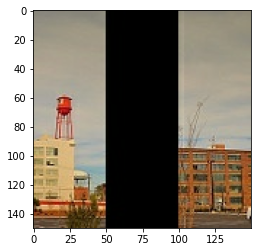

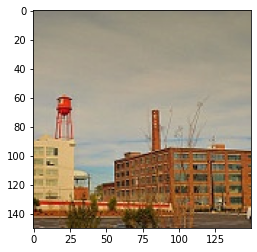

In [13]:
input_image_path, output_image_path = train_image_paths['buildings'][-1]
input_image, output_image = load(input_image_path, output_image_path)
print(input_image.shape)
print(output_image.shape)
plt.figure()
plt.imshow(input_image / MAX_PIXEL_COLOR_VALUE)
plt.figure()
plt.imshow(output_image / MAX_PIXEL_COLOR_VALUE)

In [14]:
def normalize_images(input_image, output_image) :
    input_image = (input_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1 
    output_image = (output_image / (MAX_PIXEL_COLOR_VALUE / 2)) - 1  
    return input_image, output_image

In [15]:
def resize_images(input_image, output_image, height, width): 
    input_image = tf.image.resize(input_image, [height, width])
    output_image = tf.image.resize(output_image, [height, width])
    return input_image, output_image

In [16]:
# Resizing is a must, because our Generator takes in images with the shape of (256, 256, 3)

In [17]:
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

In [18]:
def make_image_set(image_paths) :
    # lets firstly try out with only one category, and later try with all of them
    category = "street"
    images = []
    i = 0
    # TODO [vukan] : When testing on better device, remove the i check
    # for category in categories:
    for image_path_pair in image_paths[category]:
        i += 1
        input_image_path, output_image_path = image_path_pair
        input_image, output_image = load(input_image_path, output_image_path)
        input_image, output_image = resize_images(input_image, output_image, IMAGE_HEIGHT, IMAGE_WIDTH)
        images.append(normalize_images(input_image, output_image))
        if i > 300:
            break
    return images

In [19]:
train_images = make_image_set(train_image_paths)
test_images = make_image_set(test_image_paths)

In [20]:
input_image, output_image = train_images[0]

In [68]:
%run Generator.ipynb

Model: "gen"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential_91 (Sequential)  (None, 128, 128, 64)         3392      ['input_6[0][0]']             
                                                                                                  
 sequential_92 (Sequential)  (None, 64, 64, 128)          131712    ['sequential_91[0][0]']       
                                                                                                  
 sequential_93 (Sequential)  (None, 32, 32, 256)          525568    ['sequential_92[0][0]']       
                                                                                                

In [69]:
generator = Generator(input_image.shape)

In [23]:
%run Discriminator.ipynb

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 target_image (InputLayer)   [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 concatenate_14 (Concatenat  (None, 256, 256, 6)          0         ['input_image[0][0]',         
 e)                                                                  'target_image[0][0]']        
                                                                                                  
 sequential_30 (Sequential)  (None, 128, 128, 64)         6464      ['concatenate_14[0][0]']  

In [70]:
discriminator = Discriminator(input_image.shape)

In [25]:
def display_images(generator_model, input_image, output_image):
    generated_image = generator_model(input_image[tf.newaxis, ...], training=True)
    fig = plt.figure(figsize=(10, 7)) 
    rows = 1
    columns = 3
    fig.add_subplot(rows, columns, 1) 
    plt.imshow(input_image *  0.5 + 0.5)
    plt.title("Input") 
    fig.add_subplot(rows, columns, 2) 
    plt.imshow(output_image *  0.5 + 0.5)
    plt.title("Output")  
    fig.add_subplot(rows, columns, 3) 
    plt.imshow(generated_image[0] *  0.5 + 0.5)    
    plt.title("Generated") 

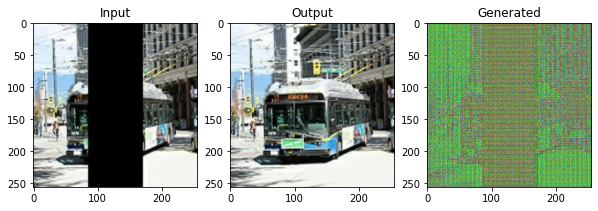

In [26]:
display_images(generator.model, input_image, output_image)

In [27]:
import datetime
import time

In [28]:
log_dir="../logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [87]:
@tf.function
def train_step(input_image, output_image, generator, discriminator, step):
    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        
        generator_model = generator.model
        discriminator_model = discriminator.model
        
        generated_image = generator_model(input_image[tf.newaxis, ...], training=True)
        discriminator_real_output = discriminator_model([input_image[tf.newaxis, ...], output_image[tf.newaxis, ...]], training=True)
        discriminator_generated_output = discriminator_model([input_image[tf.newaxis, ...], generated_image], training=True)
    
        generator_loss, cross_entropy_loss, l1_loss = generator.loss(discriminator_generated_output, generated_image, output_image)
        discriminator_loss = discriminator.loss(discriminator_real_output, discriminator_generated_output)
    
    generator_gradients = generator_tape.gradient(generator_loss, generator_model.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(discriminator_loss, discriminator_model.trainable_variables)
    
    generator.optimizer.apply_gradients(zip(generator_gradients, generator_model.trainable_variables))
    discriminator.optimizer.apply_gradients(zip(discriminator_gradients, discriminator_model.trainable_variables))
    
    with summary_writer.as_default():
        tf.summary.scalar('generator_loss', generator_loss, step=step // 1000)
        tf.summary.scalar('cross_entropy_loss', cross_entropy_loss, step=step // 1000)
        tf.summary.scalar('l1_loss', l1_loss, step=step // 1000)
        tf.summary.scalar('discriminator_loss', discriminator_loss, step=step // 1000)

In [91]:
def fit(train_images, test_images, generator, discriminator, steps):
    example_input, example_output = next(iter(test_images.take(1)))
    start = time.time()

    for step, (input_image, output_image) in train_images.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:
            #display.clear_output(wait=True)
            if step != 0:
                print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

            start = time.time()
            
            display_images(generator.model, example_input, example_output)
            print(f"Step: {step//1000}k")

        train_step(input_image, output_image, generator, discriminator, step)
        
        # Training step
        if (step + 1) % 10 == 0:
            print('.', end='', flush=True)
            display_images(generator.model, example_input, example_output)
            

        # Save (checkpoint) the model every 5k steps
        if (step + 1) % 5000 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [92]:
train_dataset = tf.data.experimental.from_list(train_images)
test_dataset = tf.data.experimental.from_list(test_images)

2024-01-06 19:45:58.831935: I tensorflow/core/grappler/optimizers/data/replicate_on_split.cc:32] Running replicate on split optimization


Step: 0k
...

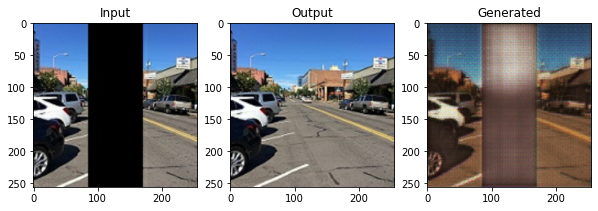

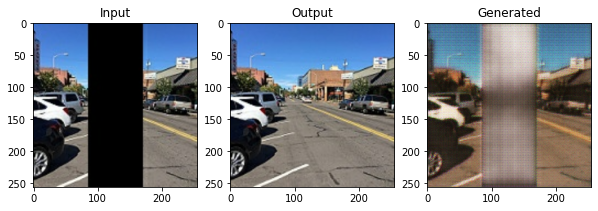

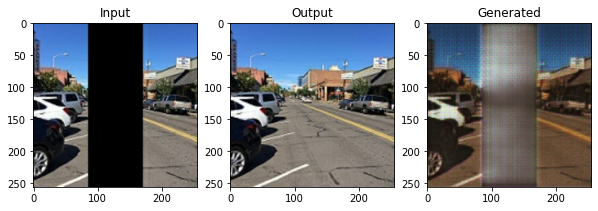

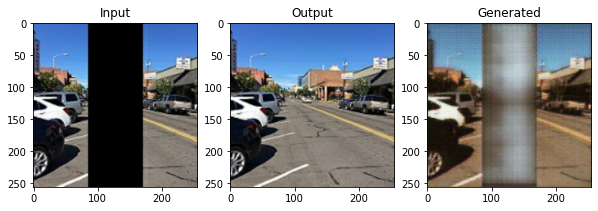

In [94]:
fit(train_dataset, test_dataset, generator, discriminator, steps=30)

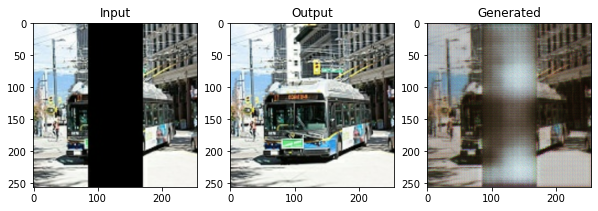

In [95]:
display_images(generator.model, input_image, output_image)